# Create CIGALE input files
Here we create the photometry files that we use as an input to [CIGALE](https://cigale.lam.fr/) (We actually use X-CIGALE, but most of the information can be found in the same web page) . First we import the Python packages.

In [1]:
%pylab

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.units as u
from astropy import coordinates
from astropy.table import Table, vstack, unique, join, Column

from os import path
from numpy import unique as uniq

We read the SMB-VCV sample file and create a table of equivalences between the different bands.

In [3]:
FinalName = Table.read('../Data/Final/VCV_SMB_otype.txt', format='ascii')
Sample = uniq(FinalName)

## Create equivalences between NED and CDS tables
Here we create a list for the different names of the bands in NED and CDS. Each row represents the same band.

In [4]:
Equival = [['2-10 keV (XMM)', None, None],
           ['0.5-2 keV (XMM)', None, None],
           ['GALEX:FUV', 'FUV (GALEX)', None],
           ['GALEX:NUV', 'NUV (GALEX)', None],
           ["SDSS:u'", 'SDSS:u', 'u (SDSS) AB'],
           ["SDSS:g'", 'SDSS:g', 'g (SDSS) AB'],
           ["SDSS:r'", 'SDSS:r', 'r (SDSS) AB'],
           ["SDSS:i'", 'SDSS:i', 'i (SDSS) AB'],
           ["SDSS:z'", 'SDSS:z', 'z (SDSS) AB'],
           ['2MASS:J', 'J (2MASS) AB', None],
           ['2MASS:H', 'H (2MASS) AB', None],
           ['2MASS:Ks', 'Ks (2MASS) AB', None],
           ['WISE:W1', 'W1 (WISE)', None],
           [':=3.6um', '3.6 microns (IRAC)', None],
           [':=4.5um', '4.5 microns (IRAC)', None],
           ['WISE:W2', 'W2 (WISE)', None],
           [':=5.8um', '5.8 microns (IRAC)', None],
           [':=8um', '8.0 microns (IRAC)', None],
           ['IRAS:12', '12 microns (IRAS)', None],
           ['WISE:W3', 'W3 (WISE)', None],
           ['WISE:W4', 'W4 (WISE)', None],
           ['Spitzer/MIPS:24', '24 microns (MIPS)', None],
           ['IRAS:25', '25 microns (IRAS)', None],
           ['IRAS:60', '60 microns (IRAS)', None],
           ['Herschel/PACS:70', '70 microns (PACS)', None],
           ['Spitzer/MIPS:70', '70 microns (MIPS)', None],
           ['IRAS:100', '100 microns (IRAS)', None],
           ['Herschel/PACS:100', '100 microns (PACS)', None],
           ['Spitzer/MIPS:160', '160 microns (MIPS)', None],
           ['Herschel/PACS:160', '160 microns (PACS)', None],
           ['Herschel/SPIRE:250', '250 microns (SPIRE)', ':=250um'],
           ['Herschel/SPIRE:350', '350 microns (SPIRE)', ':=350um'],
           ['Herschel/SPIRE:500', '500 microns (SPIRE)', ':=500um'],
           [':=5GHz', ':=6cm', '4.89 GHz (VLA)'],
           [':=1.5GHz', ':=20cm', '1.46 GHz (VLA)'],
           [':=1.4GHz', ':=21cm', '1.4GHz']
           ]

## Transform photometry to CIGALE table

We create a class that allows us to transform the units of the SEDs in the selected bands

In [8]:
class TransformCIGALE:
    """Class to plot the SEDs and create a row with the right units"""
    def __init__(self, SED):
        self.sed = SED
#         self.Iniplot() # To check the SED
        self.CreateRow()

    def Iniplot(self):
        "Plot the SED"
        errorbar(self.sed['Wave'], self.sed['Flux'], yerr=self.sed['F_er'], fmt='o')
        xlim(1e-6, 1e6)
        loglog()

    def CreateRow(self):
        """Calculate the flux and error to use for the SED in CIGALE"""
        # Number of filtets/bands and their errors
        self.row = full(72, nan)
        iband = 0
        for band in Equival:
            Crop = self.sed[np.logical_or.reduce([self.sed['Filter'] == band[0],
                                                  self.sed['Filter'] == band[1],
                                                  self.sed['Filter'] == band[2]])]
            Flux = np.mean(Crop['Flux'])
            Std = np.sqrt(np.sum(Crop['F_er']**2))/len(Crop)
            self.row[iband] = Flux*1000  # To send in mJy
            self.row[iband+1] = Std*1000  # To send in mJy
            iband += 2

We create a table with all the CIGALE bands/filters and fill it with the information that we get from NED and CDS. In some cases some of the galaxies are not useful because the bands are not found initially. This could take some minutes.

In [9]:
CIGALEFilter = ['xray_box_car_2to10keV', 'xray_box_car_0p5to2keV', 'FUV', 'NUV',
                'u_prime', 'g_prime', 'r_prime', 'i_prime', 'z_prime', 'J_2mass',
                'H_2mass', 'Ks_2mass', 'WISE1', 'IRAC1', 'IRAC2', 'WISE2', 'IRAC3', 'IRAC4',
                'IRAS1', 'WISE3', 'WISE4', 'MIPS1', 'IRAS2', 'IRAS3', 'PACS_blue', 'MIPS2',
                'IRAS4', 'PACS_green', 'MIPS3', 'PACS_red', 'PSW_ext', 'PMW_ext', 'PLW_ext',
                'VLA_C', 'VLA_L', 'HI21cm']
# VLAC is 6cm ,VLAL is 20 cm and HI21cm is 1.4GHz
CIGFilt = []
[CIGFilt.append([filt, filt+'_err']) for filt in CIGALEFilter]
CIG = Table(names=array(CIGFilt).ravel())
GoodGalaxies = []

for igal, Galaxy in enumerate(Sample['main_id']):
    #     figure()
    SED = Table.read('../SEDs/'+Galaxy+'_Phot.txt', format='ascii')
    if len(SED) == 0:
        print(Galaxy, 'No useful phot.')
    else:
        GoodGalaxies.append(igal)
        CIG.add_row(TransformCIGALE(SED).row)

/Users/users/ramos/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3370: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/users/ramos/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-8-b3394cdbbcfe>:24: RuntimeWarning: invalid value encountered in double_scalars
  Std = np.sqrt(np.sum(Crop['F_er']**2))/len(Crop)


1RXS J042710.2-624712 No useful phot.
2E  3952 No useful phot.
2QZ J014222.6-272036 No useful phot.
2QZ J020832.4-294706 No useful phot.
2QZ J024658.5-300919 No useful phot.
2QZ J214709.3-312146 No useful phot.
2QZ J214750.4-303316 No useful phot.
2QZ J214851.8-274658 No useful phot.
2QZ J220354.6-280400 No useful phot.
2QZ J220624.1-313407 No useful phot.
2QZ J221655.1-310212 No useful phot.
2QZ J225111.4-273548 No useful phot.
2QZ J225550.1-281609 No useful phot.
BOI 3C 295  48 No useful phot.
CAIRNS J130609.11+285028.6 No useful phot.
CLASXS  36 No useful phot.
CLASXS  74 No useful phot.
CLASXS 305 No useful phot.
CXOCY J033720.9-050352 No useful phot.
CXOCY J033747.8-050721 No useful phot.
CXOCY J033754.2-050915 No useful phot.
CXOCY J033756.3-045509 No useful phot.
CXOCY J125306.5-092137 No useful phot.
CXOCY J125314.6-091619 No useful phot.
HELLAS2XMM 03120035 No useful phot.
HELLAS2XMM 05370016 No useful phot.
HELLAS2XMM 50900067 No useful phot.
HELLAS2XMM J031254.0-765415 No us

After some consideration, we decided to remove the filters in the radio and X-rays wavelengths as they provide information only for a few cases. Adding the modules of X-ray, and radio in CIGALE for a few sources is not justified. 

In [10]:
CIG = CIG[CIG.colnames[4:-6]]  # Remove x-ray and radio wavelengths

We add the identifier (main_id) and the redshift from SIMBAD. 

In [11]:
col_name = Column(name='id', data=Sample['main_id'][GoodGalaxies])
CIG.add_column(col_name, 0)
col_z = Column(name='redshift', data=Sample['rvz_redshift'][GoodGalaxies])
CIG.add_column(col_z, 1)

## Clean photometric values

Then, for each filter, we verify if the relative error is higher than 33%, in those cases we do not use that information for the modeling. In addition, we remove information with limits, that in some cases are annotated as negative values. We comment the `print` commands to save space in the final notebook. 

In [12]:
for igal in range(len(CIG)):
    for icol in CIG.colnames[2::2]:
        if CIG[icol+'_err'][igal]/CIG[icol][igal] >= 1/3.:  # Higher than 33%
#             print(CIG['id'][igal], icol, CIG[icol+'_err']
#                   [igal]/CIG[icol][igal])
            CIG[icol+'_err'][igal] = np.nan
            CIG[icol][igal] = np.nan
        if CIG[icol+'_err'][igal]/CIG[icol][igal] <= 0:  # Negative Limits
#             print('Negative', CIG['id'][igal], icol)
            CIG[icol+'_err'][igal] = np.nan
            CIG[icol][igal] = np.nan

We define a minimum error for each filter to avoid overfitting

In [13]:
def AddMinError(PhotTab, ListBands, Error):
    """Function to add a minimum error for the bands"""
    for icol in ListBands:
        RelErr = PhotTab[icol+'_err']/PhotTab[icol]
        PhotTab[icol+'_err'] = np.fmax(RelErr, Error)*PhotTab[icol]

In [14]:
AddMinError(CIG, ['FUV', 'NUV'], 0.1)
AddMinError(CIG, ['u_prime', 'g_prime', 'r_prime', 'i_prime', 'z_prime'], 0.02)
AddMinError(CIG, ['J_2mass', 'H_2mass', 'Ks_2mass'], 0.02)
AddMinError(CIG, ['IRAC1', 'IRAC2', 'IRAC3', 'IRAC4'], 0.03)
AddMinError(CIG, ['MIPS1', 'MIPS2', 'MIPS3'], 0.04)
AddMinError(CIG, ['WISE1', 'WISE2', 'WISE3', 'WISE4'], 0.06)
AddMinError(CIG, ['PACS_blue', 'PACS_green', 'PACS_red'], 0.1)
AddMinError(CIG, ['PSW_ext', 'PMW_ext', 'PLW_ext'], 0.07)

## Remove galaxies without energy balance

Then, we look for galaxies where the energy balance cannot be well constrained (i.e. galaxies where there is not enough bands in the optical and IR wavelengths). As before, we comment the `print` commands to save space in the final notebook. 

In [15]:
igal = 0
BadGalaxies = []
for Lrow in CIG:
    IRPhotPoints = sum(~isnan(list(Lrow.as_void())[22:]))/2  # From WISE to PLW
    OpPhotPoints = sum(~isnan(list(Lrow.as_void())[2:22]))/2  # From FUV to Ks
    if IRPhotPoints < 3 or OpPhotPoints < 5:
#         print('Galaxy %s has %i useful photometry points' %
#               (Lrow['id'], IRPhotPoints+OpPhotPoints))
        BadGalaxies.append(igal)
    igal += 1

In [16]:
print('The total galaxies to remove is %d'%len(BadGalaxies))

The total galaxies to remove is 5743


To complement this information we plot the total photometry points in the `BadGalaxies`.

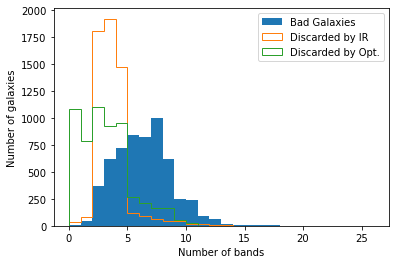

In [17]:
%matplotlib inline

Tpins = []
TpinsIR = []
TpinsOp = []
for Lrow in CIG[BadGalaxies]:
    # All the bad galaxies
    Tpins.append(sum(~isnan(list(Lrow.as_void())[2:]))/2)
    # Galaxies discarded due to IR wavelegnths
    TpinsIR.append(sum(~isnan(list(Lrow.as_void())[22:]))/2)
    # Galaxies discarded due to Opt. wavelengths
    TpinsOp.append(sum(~isnan(list(Lrow.as_void())[2:22]))/2)
hist(Tpins, bins=np.linspace(0, 26, 27), label='Bad Galaxies')
hist(TpinsIR, bins=np.linspace(0, 26, 27),
     histtype='step', label='Discarded by IR')
hist(TpinsOp, bins=np.linspace(0, 26, 27),
     histtype='step', label='Discarded by Opt.')
ylabel('Number of galaxies')
xlabel('Number of bands')
legend()

Most of the `BadGalaxies` are located in a large range of redshifts, mainly affecting galaxies at redshifts above $z=1$. This means that some of these galaxies are not well covered in some of the selected instruments and/or that the photometric values are not well constrained. 

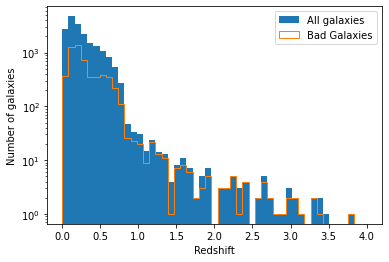

In [18]:
Redbins = np.linspace(0, 4, 50)
hist(CIG['redshift'], bins=Redbins, label='All galaxies')
hist(CIG[BadGalaxies]['redshift'], bins=Redbins, histtype='step', label='Bad Galaxies')
xlabel('Redshift')
ylabel('Number of galaxies')
yscale('log')
legend()

We save in a different file those galaxies that do not fulfill the energy balance we want. And then, we removed them from the sample.

In [19]:
CIG[BadGalaxies].write('../CIGPhot_BadEnergyBalance.tbl', format='ascii')

In [19]:
# Remove galaxies with bad energy balance coverage
CIG.remove_rows(BadGalaxies)

## Separating galaxies depending on redshift  

If we separate the samples of galaxies with redshifts we found that most of our sample is below $z=0.5$, so we are going to focus on those galaxies. The maximum redshift is $z=3.5$. Also for simplicity in CIGALE runs, it is best to work with galaxies with nearby redshifts.

We plot the distribution on redshift for the final sample. We split the sample at redshift $z<=0.5$ (Low-z), between $z>0.5$ and $z<=1$ (Intermediate-z), and $z>1$ (High-z).

Text(0, 0.5, 'Counts')

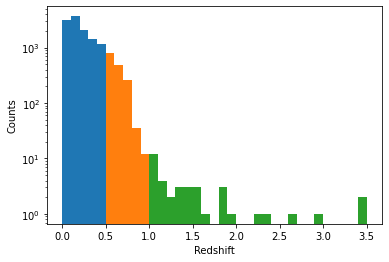

In [20]:
Highz = CIG['redshift'] > 1
Intermz = logical_and(CIG['redshift'] > 0.5, CIG['redshift'] <= 1)
Lowz = CIG['redshift'] <= 0.5

hist(CIG['redshift'][Lowz], bins=np.linspace(0, 0.5, 6), log=True)
hist(CIG['redshift'][Intermz], bins=np.linspace(0.5, 1, 6), log=True)
hist(CIG['redshift'][Highz], bins=np.linspace(1, 3.5, 26), log=True)
xlabel('Redshift')
ylabel('Counts')

In [26]:
print('The total number of galaxies per sample is:')
print('%d for Low-z, %d for Intermediate-z and %d for High-z.' %
      (sum(Lowz), sum(Intermz), sum(Highz)))

The total number of galaxies per sample is:
11502 for Low-z, 1589 for Intermediate-z and 38 for High-z.


## Create CIGALE photometry files

And finally, we save this information in different files to split the runs and avoid computational overwork in CIGALE.

In [24]:
CIG[Lowz].write('../CIGPhot_EnergyBal_Lowz.tbl', format='ascii')
CIG[Intermz].write('../CIGPhot_EnergyBal_Intz.tbl', format='ascii')
CIG[Highz].write('../CIGPhot_EnergyBal_Highz.tbl', format='ascii')
## We also save a file for all the galaxies, as in some cases this file is useful 
CIG.write('../CIGPhot_EnergyBal_All.tbl', format='ascii')

These files are used as an input to CIGALE (Step 5), not show as a notebook. 

##### Notebook info

In [27]:
%load_ext watermark
%watermark -a "Andres Ramos" -d -v -m
print('Specific Python packages')
%watermark -iv -w --packages astropy

Author: Andres Ramos

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.16.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 3.10.0-1160.25.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
astropy: 4.2

numpy     : 1.19.5
sys       : 3.8.3 (default, Jul  2 2020, 16:21:59) 
[GCC 7.3.0]
re        : 2.2.1
autopep8  : 1.5.4
astropy   : 4.2
matplotlib: 3.2.2
logging   : 0.5.1.2
json      : 2.0.9

Watermark: 2.1.0

